#### NOTE ABOUT THE PSD CALCULATIONS
Throwing away steps 4, 5 from each optic because they have a strange defocus component.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
np.set_printoptions(suppress=True) # scientific notation gets annoying
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx
from model_kit import zernike as zern
from model_kit import dust
import poppy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 11/11/2020 15:16:43


In [2]:
# initialize the data
tot_fm = 8 # all flats
tot_step= 4 # the last 2 step sets are bad news 
fits_folder = 'flat_mirrors/fixed_fits/'
raw_folder = 'flat_mirrors/2018_03_23/'

opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 0.025*u.m, #25*u.mm,
             'label': '1in',
             'ring_width': 5,
             'kmid_ll': 100 * u.m, #0.1/u.mm,
             'khigh_ll': 1000 * u.m} #1/u.mm}

for fmn in range(0, tot_fm):
    fm_num = fmn+1
    for ns in range(0, tot_step):
        # call in the file
        fm_loc = raw_folder+'flat_{0}_n{1}_100percent_step{2}.datx'.format(opt_parms['label'],fm_num, ns)
        surf, mask, sp = dfx.open_datx(datx_file_loc=fm_loc, diam_ca100=opt_parms['diam_100CA'])
        wavelen = sp['value'][sp['label'].index('wavelen')] # should be same for all steps
        latres = sp['value'][sp['label'].index('latres')]

        if ns==0 and fmn==0:
            opt_parms['surf_units'] = sp['value'][sp['label'].index('surfunit')]
            opt_parms['wavelen'] = wavelen
            opt_parms['latres'] = latres
        
        # tighten up the matrix by removing empty rows and columns
        surf, mask = dfx.mat_tight(surf, mask)

        # apply a resize
        surf, mask = dfx.reduce_ca(data=surf, mask=mask, old_ca=100, new_ca=opt_parms['ca']) 
        # write data to a matrix
        if ns==0 and fmn==0: # initialize first time
            opt_parms['diam_ca'] = mask.shape[0]*latres#.to(u.mm/u.pix)
            data_set = np.zeros((tot_fm, tot_step, mask.shape[0], mask.shape[0])) # initialize
        data_set[fmn, ns, :, :] = surf.value

    print('Completed flat mirror n{0} file opening to local environment'.format(fm_num))
            
raw_surf = data_set * surf.unit
raw_mask = mask

Completed flat mirror n1 file opening to local environment
Completed flat mirror n2 file opening to local environment
Completed flat mirror n3 file opening to local environment
Completed flat mirror n4 file opening to local environment
Completed flat mirror n5 file opening to local environment
Completed flat mirror n6 file opening to local environment
Completed flat mirror n7 file opening to local environment
Completed flat mirror n8 file opening to local environment


In [3]:
# create all the dust maps.
# All dust pieces are in pixel values

# center of dust based on n8 flat
dcen_x = ([[ 0,  81, 117, 153],#  0,   0],
           [91, 127, 163,   0],#  0,   0],
           [ 0,   0,  14,  49]])#, 86, 122]])
dcen_y = [13, 27, 97]
dust_radius=15 # oversize for everyone, not many pixels to lose
x_offset = [5, -3, 4, 2, 2, 1, -1, 0]
y_offset = [0,  2, 2, 1, 2, 1, 1, 0]

# step 0 big dust mask
box_corner_c = [210, 202, 208, 206, 206, 206, 202, 202]
box_corner_r = [114, 114, 114, 114, 114, 114, 114, 114]
box_rsize =    [28,   28,  28,  28,  28,  28,  28,  28]
box_csize =    [ 8,   16,  10,  12,  12,  12,  16,  16]

# build dust lists
dust_set = np.zeros_like(data_set)

# Build Zernike listing
zm_cor_ptt = np.zeros_like(data_set)
nt_ptt = 3

# This loop masks the dust per step for all the optics
for nf in range(0, tot_fm): # choose optic
    fm_num = nf+1
    opt_parms['fm_num'] = nf+1
    
    # build all dust mask
    all_dust = np.ones((tot_step, mask.shape[0], mask.shape[1]))
    
    # analyzing per step
    for ns in range(0, tot_step):
        opt_parms['step_num'] = ns
        mask_step = np.ones_like(mask).astype(float) # initialize step mask
        
        # Apply specific dust mask present in all steps at same place
        if fm_num == 2:
            mark_coord = draw.circle(r=138, c=197, radius=9)
            mask_step[mark_coord] = 0 #np.nan
            mask_fits = copy.copy(mask)
            mask_fits[mark_coord] = 0
        elif fm_num == 4:
            mark_coord = draw.circle(r=96, c=49, radius=9)
            mask_step[mark_coord] = 0# np.nan
            mask_fits = copy.copy(mask)
            mask_fits[mark_coord] = 0
        
        # for the first step mask ONLY, need to apply a box to clean up a single dust piece.
        if ns==0:
            mask_step[box_corner_r[nf]:box_corner_r[nf]+box_rsize[nf], 
                      box_corner_c[nf]:box_corner_c[nf]+box_csize[nf]] = 0 #np.nan
        
        # build each dust location at the step
        for nd in range(0, np.shape(dcen_x)[0]): 
            dmc = np.zeros_like(mask)
            if dcen_x[nd][ns] != 0: # if there is a value, then make a mask. Otherwise, skip.
                dm_coord = draw.circle(r=dcen_y[nd]+y_offset[nf], 
                                       c=dcen_x[nd][ns]+x_offset[nf],
                                       radius=dust_radius)
                dmc[dm_coord] = True
            mask_step[dmc==True] = 0 #np.nan
        all_dust[ns] = mask_step * mask
        
        # for the dust mask made in the optic and step, remove the Zernike of surface.
        zm_cor_ptt[nf][ns] = dfx.apply_zern_arb(raw_surf = raw_surf[nf][ns], 
                                                dust_mask = all_dust[ns],
                                                nt = nt_ptt,
                                                opt_parms = opt_parms,
                                                write_file = True,
                                                folder_loc=fits_folder).value
        #print('Dust masked and Surface with Z{0} removed for n{1}s{2}'.format(nt_ptt, nf, ns))
        
    # Save the dust information
    dust_set[nf] = all_dust
    #print('-------------------')
    print('Dust masked and surface with Z{0} removed for all steps in n{1}'.format(nt_ptt, nf+1))

# apply the units for the zernike surface
zm_cor_ptt = zm_cor_ptt * raw_surf.unit

# remove the terms from the dictionary, only temporary
del opt_parms['fm_num']
del opt_parms['step_num']

Dust masked and surface with Z3 removed for all steps in n1
Dust masked and surface with Z3 removed for all steps in n2
Dust masked and surface with Z3 removed for all steps in n3
Dust masked and surface with Z3 removed for all steps in n4
Dust masked and surface with Z3 removed for all steps in n5
Dust masked and surface with Z3 removed for all steps in n6
Dust masked and surface with Z3 removed for all steps in n7
Dust masked and surface with Z3 removed for all steps in n8


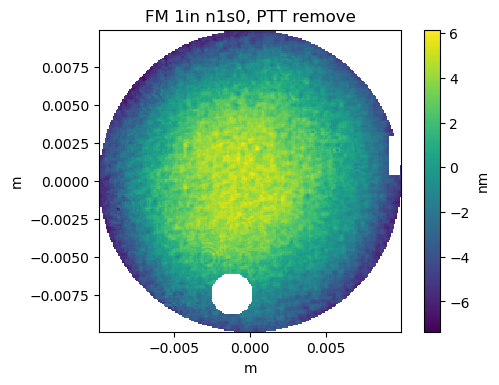

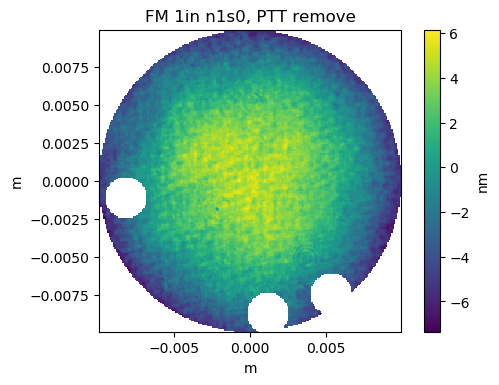

In [4]:
fmn1 = 0
sn1 = 0
fmn2 = 0
sn2 = 2

data1 = zm_cor_ptt[fmn1][sn1].to(u.nm)
data2 = zm_cor_ptt[fmn2][sn2].to(u.nm)

data1_sn = dfx.sn_map(surface=data1.value, mask=dust_set[fmn1][sn1])
data2_sn = dfx.sn_map(surface=data2.value, mask=dust_set[fmn2][sn2])

vmin = np.amin([np.amin(data1.value), np.amin(data2.value)])
vmax = np.amax([np.amax(data1.value), np.amax(data2.value)])

dfx.show_image(data=data1_sn,
              data_unit = data1.unit,
              pixscale=(latres*u.pix),#.to(u.mm),
              fig_title='FM {0} n{1}s{2}, PTT remove'.format(opt_parms['label'], fmn1+1, sn1),
              cbar_lim=[vmin, vmax])

dfx.show_image(data=data2_sn,
              data_unit = data2.unit,
              pixscale=(latres*u.pix),#.to(u.mm),
              fig_title='FM {0} n{1}s{2}, PTT remove'.format(opt_parms['label'], fmn1+1, sn1),
              cbar_lim=[vmin, vmax])

NOTE: The PSDs are calculated in a separate .py script (mvls_fm_1in_all.py) to allow overnight calculations.

In [5]:
%%time
# call in the PSDs and take the radial profiles
# PSDs are calculated in separate script because it can take forever
nt_ptt = 3
psd_folder = 'flat_mirrors/mvls_psd/'
pos_count = 0
psd_avg = np.zeros_like(mask)
for nf in range(0, tot_fm): # choose optic
    fm_num = nf+1
    
    for ns in range(0, tot_step):
        mvls_name = 'lspsd_fm_{0}_n{1}_step{2}_z{3}.fits'.format(opt_parms['label'],fm_num,ns,nt_ptt)
        fm_psd_fits = fits.open(psd_folder+mvls_name)[0]
        psd_avg = psd_avg + fm_psd_fits.data # unitless for now
        fm_psd = fm_psd_fits.data * (u.nm*u.m)**2 # manually place in the data
        fm_dk = fm_psd_fits.header['delta_k'] / u.m
        #fm_psd = fm_psd_fits.data * (u.nm*u.mm)**2 # manually place in the data
        #fm_dk = fm_psd_fits.header['delta_k'] / u.mm

        # build the radial frequency
        cen = int(fm_psd.shape[0]/2)
        if fm_psd.shape[0] % 2 != 0: # odd length
            radial_freq = np.linspace(-cen, cen, fm_psd.shape[0]) * fm_dk
        else:
            radial_freq = np.linspace(-cen, cen-1, fm_psd.shape[0]) * fm_dk
        radial_freq = radial_freq[cen:].value

        # calculate the radial PSD data
        k_radial, psd_radial = psd.do_psd_radial(psd_data=fm_psd, delta_k=fm_dk, ring_width=3, kmin=None)
        #k_radial, psd_radial = psd.new_psd_radial(psd_data=fm_psd, radial_freq=radial_freq)

        # initialize all the variables
        if ns==0 and nf == 0:
            ptt_k_radial = np.zeros((tot_fm, tot_step, len(k_radial)))
            ptt_psd_radial = np.zeros_like(ptt_k_radial)
        
        ptt_k_radial[nf][ns] = np.asarray(k_radial)
        ptt_psd_radial[nf][ns] = np.asarray(psd_radial)

# apply units
ptt_k_radial = ptt_k_radial * fm_dk.unit
ptt_psd_radial = ptt_psd_radial * fm_psd.unit

# Calculate the average
psd_avg = (psd_avg / (tot_fm*tot_step)) * fm_psd.unit
ptt_avg_k_radial, ptt_avg_psd_radial = psd.do_psd_radial(psd_data=psd_avg, delta_k=fm_dk, ring_width=3, kmin=None)
#ptt_avg_k_radial, ptt_avg_psd_radial = psd.new_psd_radial(psd_data=psd_avg, radial_freq=radial_freq)

CPU times: user 909 ms, sys: 5.31 ms, total: 915 ms
Wall time: 970 ms


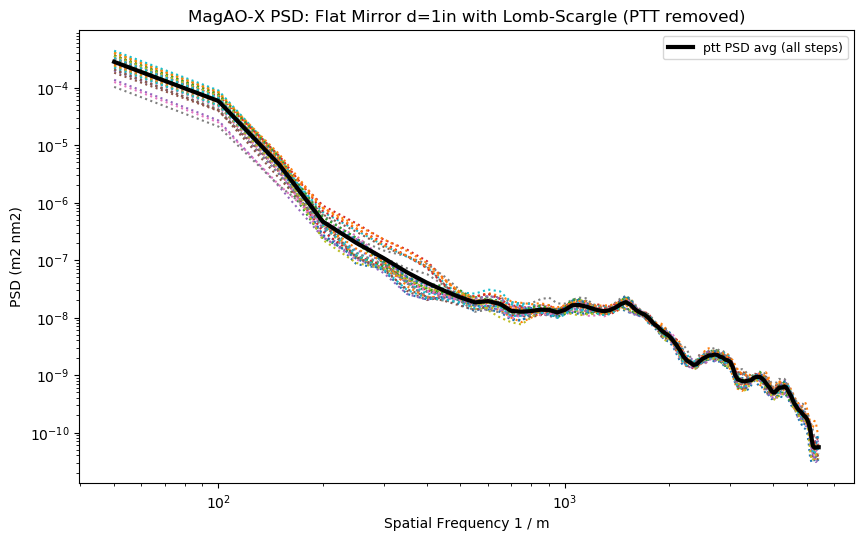

In [6]:
plt.figure(figsize=[10,6], dpi=100)
for nf in range(0, tot_fm):
    for ns in range(0, tot_step):
        plt.loglog(ptt_k_radial[nf][ns].value, ptt_psd_radial[nf][ns].value, ':')#, label='ptt n{1}_s{2}'.format(nt, nf,ns))
plt.loglog(ptt_avg_k_radial, ptt_avg_psd_radial, 'k', linewidth=3, label='ptt PSD avg (all steps)')
plt.xlabel('Spatial Frequency {0}'.format(fm_dk.unit))
plt.ylabel('PSD ({0})'.format(fm_psd.unit))
plt.title('MagAO-X PSD: Flat Mirror d={0} with Lomb-Scargle (PTT removed)'.format(opt_parms['label']))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
# Write average PSD to file for easy access during modeling in separate notebook
hdr = fits.Header()
hdr['psd_unit'] = (str(psd_avg.unit), 'Units for PSD data')
hdr['wavelen'] = (opt_parms['wavelen'].value, 
                  'Wavelenth used in optical test [{0}]'.format(opt_parms['wavelen'].unit))
hdr['diam_ca'] = (opt_parms['diam_ca'].value, 
                  'Physical diameter for clear aperture [{0}]'.format(opt_parms['diam_ca'].unit))
hdr['diam_pix'] = (mask.shape[0],
                  'Pixel diameter for clear aperture')
hdr['ca_perc'] = (opt_parms['ca'],
                  'Percent of clear aperture')
hdr['delta_k'] = (fm_dk.value,
                  'Spatial frequency lateral resolution [{0}]'.format(fm_dk.unit))
hdr['k_min'] = (1/opt_parms['diam_ca'].value,
                'Minimum spatial frequency boundary [{0}]'.format(fm_dk.unit))
hdr['k_max'] = (1/(2*opt_parms['diam_ca'].value/mask.shape[0]),
                'Maximum spatial frequency boundary [{0}]'.format(fm_dk.unit))
hdr['comment'] = 'If delta_k and k_min look like the same number, it is coincidence.'
hdr['comment'] = 'Note: delta_k is calculated from Lomb-Scargle, not the FFT oversample.'

psd_folder = 'flat_mirrors/mvls_psd/'
avg_psd_filename = psd_folder + 'lspsd_fm_{0}_avg_z{1}.fits'.format(opt_parms['label'], nt_ptt)
#fits.writeto(avg_psd_filename, psd_avg.value, hdr, overwrite=True)

In [8]:
hdr

PSD_UNIT= 'm2 nm2  '           / Units for PSD data                             
WAVELEN =            6.328E-07 / Wavelenth used in optical test [m]             
DIAM_CA =  0.01998175182481752 / Physical diameter for clear aperture [m / pix] 
DIAM_PIX=                  219 / Pixel diameter for clear aperture              
CA_PERC =                   80 / Percent of clear aperture                      
DELTA_K =    50.04566210045665 / Spatial frequency lateral resolution [1 / m]   
K_MIN   =    50.04566210045662 / Minimum spatial frequency boundary [1 / m]     
K_MAX   =    5479.999999999999 / Maximum spatial frequency boundary [1 / m]     
COMMENT If delta_k and k_min look like the same number, it is coincidence.      
COMMENT Note: delta_k is calculated from Lomb-Scargle, not the FFT oversample.  